In [106]:
import numpy as np
import pandas as pd
import optuna
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier

# Загрузим данные

- Данные упорядочены по времени
- Задача - предсказать `target`
- Фичи - `feature_i`
- Трейн, валидация и тест уже определены (см. колонку `sample_part`)

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/WreJPgb9pJS687D). Пароль в канале курса.

In [107]:
df = pd.read_parquet('df.parquet.gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 22620 to 310653
Columns: 235 entries, date to sample_part
dtypes: category(2), datetime64[ms](1), datetime64[us](2), float64(220), int64(9), object(1)
memory usage: 893.6+ MB


In [108]:
df.head()

,date,month,quarter,feature_217,feature_66,feature_9,feature_193,feature_15,feature_199,feature_25,...,feature_20,feature_188,feature_71,feature_106,feature_14,feature_92,feature_179,feature_102,target,sample_part
22620,2021-01-01,2021-01-01,2021-01-01,1.180855,0.483118,13.976791,1.135021,43.271792,-46.888875,97.558366,...,23.745198,-32.001093,85.489903,1.454045,-195.725786,3.719083,1,-28.813537,0.0,train
478621,2021-01-01,2021-01-01,2021-01-01,3.427814,0.886778,27.158209,-0.378728,80.087863,-67.242703,105.803406,...,22.902111,-37.436243,71.735619,1.657242,-176.250404,3.277817,1,-45.987721,1.0,train
372254,2021-01-01,2021-01-01,2021-01-01,-38.555018,1.227175,19.893873,0.498787,98.464365,-67.402522,81.858076,...,21.848414,-51.872841,65.363236,1.626874,-178.116798,2.028950,0,-31.074122,1.0,train
2596,2021-01-01,2021-01-01,2021-01-01,-14.666558,0.753129,18.203010,-1.200014,117.331340,-25.557745,90.277266,...,26.134586,-49.703003,65.013659,1.170023,-192.232264,2.218177,1,-36.703897,0.0,train
216892,2021-01-01,2021-01-01,2021-01-01,6.734990,1.129100,11.245920,-0.108955,61.205722,-78.397406,82.637472,...,24.201039,-41.070219,69.986127,1.630795,-200.155528,3.055104,1,-44.672299,1.0,train


In [109]:
TARGET = 'target'
N_FEATURES = 230
features = [f'feature_{i}' for i in range(N_FEATURES)]

# Первичный отбор признаков... (1 балл)

**Задание:** Сначала отсеем совсем уж мусорные признаки.

Воспользовавшись вашим кодом для вычисления `IV` из прошлой домашки, для всех **числовых** фичей вычислите `IV` на 20 бакетах. Отсейте признаки с `IV < 0.005`.

**Hint:** паркет не всегда сохраняет `dtype` колонки. Чтобы проверить признаки на "реальный" тип данных, лучше на всякий случай посмотреть на `nunique` 

In [110]:
cout_uniq = df[df.columns[:-2]].nunique()
cout_uniq

date              729
month              24
quarter             8
feature_217    500000
feature_66     500000
                ...  
feature_106    500000
feature_14     500000
feature_92     500000
feature_179         2
feature_102    500000
Length: 233, dtype: int64

In [111]:
cout_uniq.sort_values().unique()

array([     2,      3,      4,      8,     12,     13,     24,     52,
          729, 426512, 426722, 426740, 428147, 428264, 429584, 430915,
       431160, 433196, 433220, 434661, 436182, 436469, 436884, 438120,
       441016, 441168, 441215, 441733, 442157, 442373, 442981, 444524,
       444677, 446055, 446186, 446201, 446783, 447453, 447817, 447967,
       449760, 451427, 453265, 453313, 453684, 453958, 454015, 454445,
       454535, 455464, 456351, 456399, 456745, 457618, 457996, 458384,
       459189, 463759, 464135, 465525, 466458, 467653, 468355, 468536,
       468605, 468640, 469446, 469517, 471081, 471578, 472523, 472654,
       473840, 478743, 500000], dtype=int64)

Как мы видим, большая часть признаков все таки числовые, тк у них очень много уникальных значений, поэтому сейчас будем отбирать категориальные

In [112]:
categorical = cout_uniq[cout_uniq<1000].index.to_numpy()
numeric = cout_uniq[cout_uniq>1000].index.to_numpy()

In [113]:
from scipy.special import logit
from typing import Union, Tuple

def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""
    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

def calc_iv(
        column : np.ndarray,
        n_buckets : int,
        target : np.ndarray
    ) -> float:

    offset = logit(np.sum(target) / len(target))
    buckets = calc_buckets(column, n_buckets)
    bad_for_target = np.sum(target)
    good_for_target =len(target) - np.sum(target)
    IV = 0
    
    for bucket in np.unique(buckets):
        # Выбираем только соответствующие текущему бакету значения
        mask = (buckets == bucket)
        target_for_bucket = target[mask]
        bad_for_bucket = np.sum(target_for_bucket)
        good_for_bucket = len(target_for_bucket) - np.sum(target_for_bucket)

        badrate = max(0.001, min(0.999, np.sum(target_for_bucket) / len(target_for_bucket))) #делаем так, чтобы badrate лежал в диапазоне от 0.001 до 0.999
        woe_for_bucket = logit(badrate) - offset

        # Вычисляем IV
        IV += (bad_for_bucket / bad_for_target - good_for_bucket / good_for_target) * woe_for_bucket
    return IV


In [114]:
target = df.target.values
iv_for_numeric_features = df[numeric].apply(lambda x: calc_iv(x, 20, target))

c:\Users\kamil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\series.py:953: RuntimeWarning:

invalid value encountered in cast



numpy ругается на присутствие NaNов, но я немного пролистал задание дальше и увидел что мы будем обрабатывать это потом)

In [115]:
numeric_features_with_good_iv = iv_for_numeric_features[iv_for_numeric_features >= 0.005].index
numeric_features_with_good_iv

Index(['feature_9', 'feature_15', 'feature_154', 'feature_218', 'feature_96',
       'feature_223', 'feature_30', 'feature_225', 'feature_162',
       'feature_167', 'feature_109', 'feature_124', 'feature_79',
       'feature_213', 'feature_117', 'feature_38', 'feature_24', 'feature_75',
       'feature_5', 'feature_56', 'feature_114', 'feature_139', 'feature_142',
       'feature_12', 'feature_35', 'feature_227', 'feature_115', 'feature_155',
       'feature_132', 'feature_76', 'feature_97', 'feature_135', 'feature_26',
       'feature_2', 'feature_46', 'feature_100', 'feature_111', 'feature_164',
       'feature_98', 'feature_36', 'feature_183', 'feature_27', 'feature_4',
       'feature_32', 'feature_206', 'feature_172', 'feature_70', 'feature_44',
       'feature_23', 'feature_170', 'feature_39', 'feature_94', 'feature_43'],
      dtype='object')

**Вопрос**: Почему некорректно сравнивать `IV` у категориальных и числовых фичей?

**Ответ:** Насколько я понимаю, это связано с количеством уникальных значений, которых у категориальных фичей обычно не много. Раз у нас мало уникальных значений, значит в кажом бакете у нас будут лежать таргеты соответствующие только одной категории, то есть в бакетах практически никак не будет учитываться разнообразность признака.

Вычислите IV для категориальных фичей на `n` бакетах, где `n = min(число категорий фичи, 20)`. Возможно, придётся перекодировать некоторые фичи (*только не OneHot-ом!*)

*Опционально*: примените также и к категориальным фичам предварительный отбор по `IV` с менее строгим порогом

Все даты закодируем с помощью label encoding, остальное оставим как есть, с ними уже LightGBM справится

In [116]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['encoded_date'] = (label_encoder.fit_transform(df['date']))
df['encoded_quarter'] = (label_encoder.fit_transform(df['quarter']))
df['encoded_month'] = (label_encoder.fit_transform(df['month']))

categorical = np.where(categorical == 'date', 'encoded_date', categorical)#заменяем старые даты на новые закодированные в массиве категориальных признаков, тк первоначальные даты я дропать не хочу
categorical = np.where(categorical == 'quarter', 'encoded_quarter', categorical)
categorical = np.where(categorical == 'month', 'encoded_month', categorical)


In [117]:
target = df.target.values
iv_for_categorical_features= df[categorical].apply(lambda x: calc_iv(x, 20, target))

c:\Users\kamil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\series.py:953: RuntimeWarning:

invalid value encountered in cast

c:\Users\kamil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\series.py:953: RuntimeWarning:

invalid value encountered in cast



In [118]:
categorical_features_with_good_iv = iv_for_categorical_features[iv_for_categorical_features >= 0.0002].index
categorical_features_with_good_iv

Index(['encoded_date', 'feature_147', 'feature_144', 'feature_168',
       'feature_165', 'feature_10', 'feature_31', 'feature_140', 'feature_0',
       'feature_161', 'feature_209', 'feature_62'],
      dtype='object')

Я выбрал такой порог для IV, чтобы прошел хотя бы один признак с датой. В данном случае это date.

# Бустинг

## Подбор гиперпараметров бустинга (2 балла)

Теперь подберем оптимальные гиперпараметры бустинга.

In [119]:
# В переменную features_optuna положите список признаков с предыдущего шага
features_optuna = np.concatenate([numeric_features_with_good_iv.values,categorical_features_with_good_iv.values])

**Задание:** Заполните пропуски в коде ниже и подберите оптимальные гиперпараметры.

Для успешного решения необходимо преодолеть порог ROC-AUC `0.725` на тестовой выборке.

In [120]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves',2, 200),
        'n_estimators': trial.suggest_int('n_estimators',100,500),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples',15,30),
        'reg_lambda' : trial.suggest_float('reg_lambda',0.001,10, log=True),
        'reg_alpha' : trial.suggest_float('reg_alpha',0.001,10, log=True),
        #####
        # your code here
        # Тут вы можете добавить любые гиперпараметры LGBMClassifier (например, что-то из того, что разбирали в лекции)
        #####
        'random_state': 42
    }
    
    clf = LGBMClassifier(**params)
    clf.fit(
        X=df.loc[df['sample_part'] == 'train', features_optuna],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )
    
    return auc_valid

In [121]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=50)

In [122]:
#print(study.best_params)

In [123]:
#я несколько раз запускал подбор параметров и в итоге лучший результат выдал этот набор
best_par = {'learning_rate': 0.07372705985261675, 'num_leaves': 176, 'n_estimators': 477, 'subsample': 0.2991329449919967, 'colsample_bytree': 0.49788518804587684, 'min_child_samples': 16, 'reg_lambda': 0.011882399032408415, 'reg_alpha': 6.091677273067518}

In [124]:
clf = LGBMClassifier(**best_par)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
assert auc_test > 0.725, f'Необходимое значение ROC-AUC 0.725 и выше, ваше значение: {auc_test}!'

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13844
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


In [125]:
auc_test

0.7377466070925979

## Кривые накопления (1 балл)

**Задание:** Отрисуйте кривые накопления `ROC AUC` от `n_estimators` для бустинга с гиперпараметрами из предыдущего пункта.

**Hint:** для получения auc на каждой итерации обучения `LGBMClassifier`, можно воспользоваться параметрами `eval_set`, `eval_metric` и в методе `fit`. 

In [126]:
eval_set_val = (df.loc[df['sample_part'] == 'val', features_optuna],df.loc[df['sample_part'] == 'val', TARGET])
eval_set_train = (df.loc[df['sample_part'] == 'train', features_optuna],df.loc[df['sample_part'] == 'train', TARGET])
clf_val = LGBMClassifier(**best_par)
clf_train = LGBMClassifier(**best_par)
clf_val.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET],
    eval_set = eval_set_val,
    eval_metric = 'auc',
)
clf_train.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET],
    eval_set = eval_set_train,
    eval_metric = 'auc',
)

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13844
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13844
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


LGBMClassifier(colsample_bytree=0.49788518804587684,
               learning_rate=0.07372705985261675, min_child_samples=16,
               n_estimators=477, num_leaves=176, reg_alpha=6.091677273067518,
               reg_lambda=0.011882399032408415, subsample=0.2991329449919967)

In [127]:
import plotly.graph_objects as go

results_val = clf_val.evals_result_
n_estimators_val = len(results_val['valid_0']['auc'])
roc_auc_scores_val = results_val['valid_0']['auc']

results_train = clf_train.evals_result_
n_estimators_train = len(results_train['valid_0']['auc'])
roc_auc_scores_train = results_train['valid_0']['auc']

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(roc_auc_scores_val)) + 1, y=roc_auc_scores_val, mode='lines', name='validation'))
fig.add_trace(go.Scatter(x=np.arange(len(roc_auc_scores_train)) + 1, y=roc_auc_scores_train, mode='lines', name='train'))
fig.update_layout(xaxis_title='n_estimators', yaxis_title='roc_auc')
fig.show()

**Вопрос:** Что вы видите на полученных графиках? 

Нужно ли "обрезать" количество деревьев? Ответ обоснуйте.

**Ответ:** Как и ожидалось, на трейне с увеличением количества деревьев качество значительно увеличивается. На валидации рост качества с увеличением количества деревьев не останавливается, рост совсем незначительный, но он все же есть. Поэтому ответ на вопрос нужно ли нам обрезать количество деревьев зависит от того, насколько мы готовы пренебречь этим небольшим ростом качества для увеличения скорости. Я не готов поэтому обрезать не буду.
 

## Важность признаков (1 балл)

**Задание:** Постойте гистограмму важности признаков по `split` и `gain` для бустинга из предыдущего пункта.

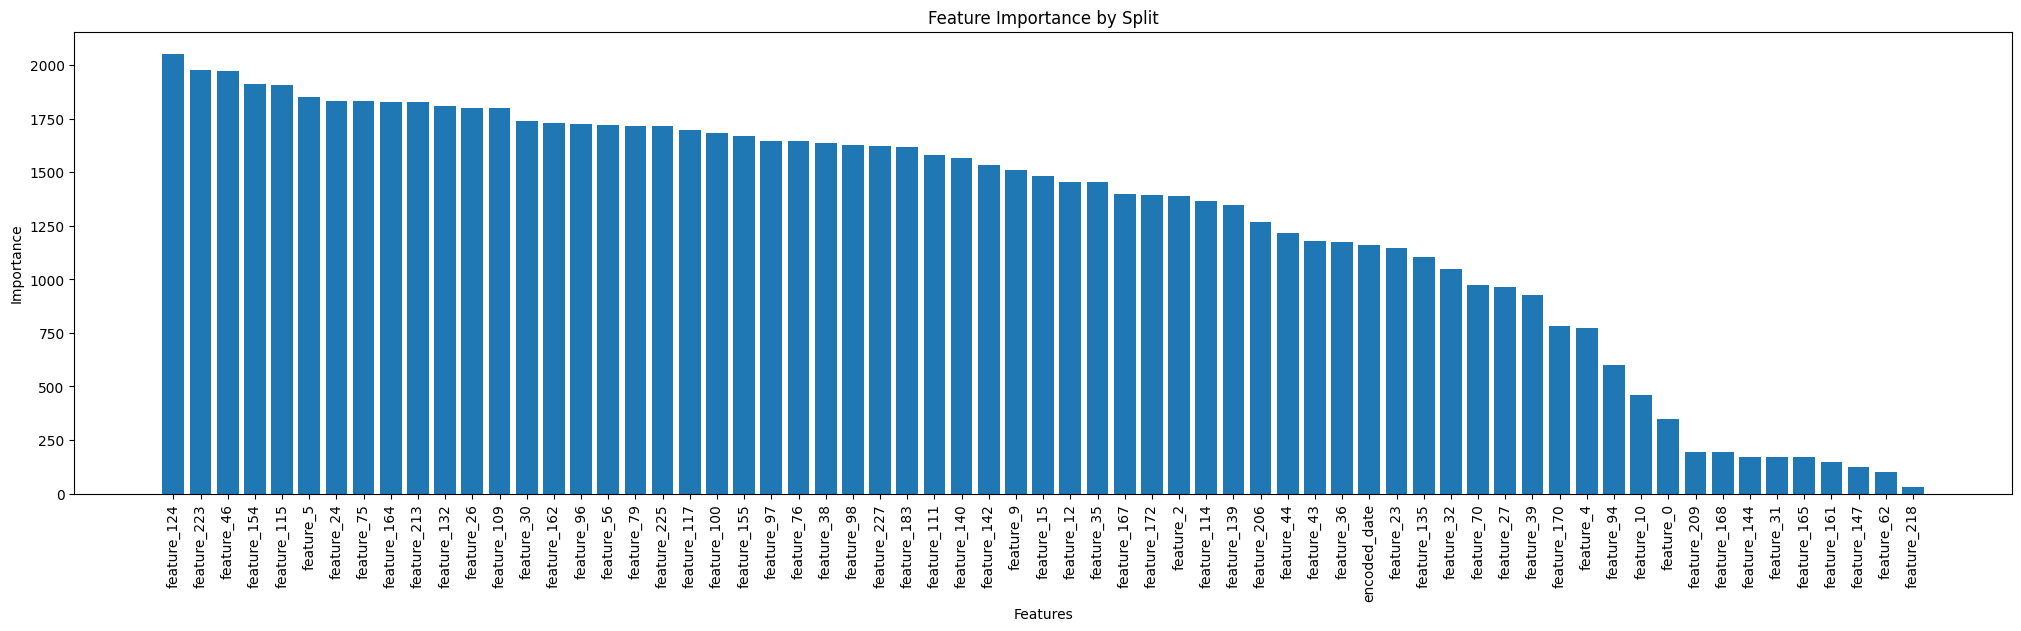

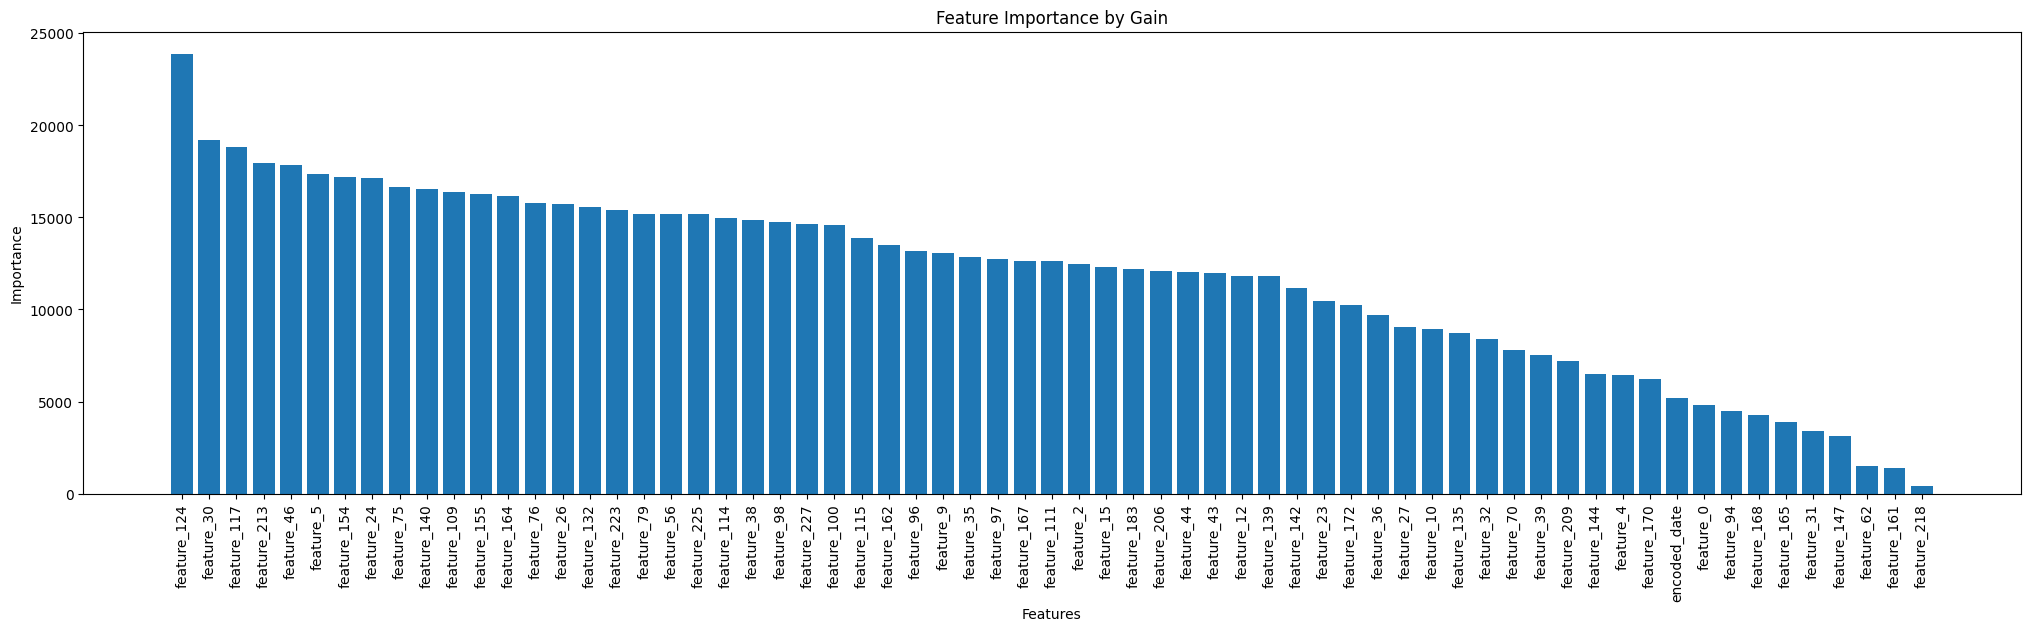

In [128]:
feature_importance_split = clf.feature_importances_
feature_importance_gain = clf.booster_.feature_importance(importance_type='gain')

# Сортировка признаков по важности
sorted_idx_split = np.argsort(feature_importance_split)[::-1]
sorted_idx_gain = np.argsort(feature_importance_gain)[::-1]

plt.figure(figsize=(25, 6))
plt.bar(range(len(sorted_idx_split)), feature_importance_split[sorted_idx_split])
plt.xticks(range(len(sorted_idx_split)), [features_optuna[i] for i in sorted_idx_split], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance by Split')
plt.show()

plt.figure(figsize=(25, 6))
plt.bar(range(len(sorted_idx_gain)), feature_importance_gain[sorted_idx_gain])
plt.xticks(range(len(sorted_idx_gain)), [features_optuna[i] for i in sorted_idx_gain], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance by Gain')
plt.show()

**Вопрос:** Какие выводы можно сделать из полученных графиков?

**Ответ:** 218 фича имеет самую худшую важность как и по split, так и по gain. 124 наоборот самая важная. По поводу остальных сложно что то сказать, так как они имеют разное место по важности в зависимости от способа.

# Логрег

## plot_metric_time (1 балл)

**Задание:** Реализуйте функцию plot_metric_time, которая будет принимать на вход четыре аргумента, а именно: 
- массив значений фичи, 
- массив значений таргета,
- массив времени (аггрегированного по месяцам или кварталам, то есть `month` или `quarter` в вашей задаче, по дням рисовать не надо),
- метрику, которую необходимо отрисовать (нужно реализовать функцию для двух метрик: `IV` и `roc_auc`)
- число бакетов для вычисления `IV`, если выбрана эта метрика

Можете добваить какие-то ещё аргументы, если вам нужно

Если в фиче есть пропуски, функция должна убирать строки с пропусками из рассмотрения

**Hint**: можно, конечно, реализовать эту функцию через цикл, а можно попробовать разобраться и реализовать её через пандасовские `groupby` -> `apply`, это изящнее и быстрее

In [129]:
import plotly.graph_objects as go

In [215]:
def plot_metric_time(
        values: pd.Series,
        target: pd.Series,
        time: pd.Series,
        metric: str = 'IV',
        n_buckets_for_IV: int = 15
) -> go.Figure:
    
    df = pd.DataFrame({'feature': values, 'target': target, 'time': time})
    df = df.dropna()
    
    values_of_metric = None
    if metric == 'IV':
        values_of_metric =df.groupby('time')[['feature','target']].apply(lambda x: calc_iv(x.feature, n_buckets_for_IV, x.target))
    elif metric == 'roc_auc':
        values_of_metric = df.groupby('time')[['feature','target']].apply(lambda x: roc_auc_score(x.target,x.feature))
    else:
        raise NotImplementedError("only 'IV' and 'roc_auc' metrics are implemented")

    plot_title = f'{values.name} {metric} in time'
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x= values_of_metric.index,
            y= values_of_metric.values,
            mode='markers+lines',
            name=values.name
            ))
    fig.update_layout(
            title_text=plot_title,
            yaxis=dict(title=metric),
            width=1000,
            height=450,
            xaxis=dict(
                domain=[0, .95],
                showgrid=True,
                tickvals= values_of_metric.index
                ),
            margin=dict(l=30, r=30, b=30, t=50),
            )
    fig.show()

    # return fig

In [216]:
# примерно так это должно будет выглядеть
plot_metric_time(df['feature_224'], df['target'], df['quarter']) 

**Задание:** Возьмите **топ-15** фичей получившегося бустинга по важности по `gain`. Отрисуйте для них графики стабильности по `IV` во времени и удалите из рассмотрения те признаки, качество которых деградирует

**NB!** Обращайте внимание на масштаб оси *y!* Иногда признак стабильнее, чем кажется)

Если вам это мешает, можете поменять ось *y*, чтобы она начиналась от нуля в прошлом задании.

In [132]:
top15features_stable =[features_optuna[i] for i in sorted_idx_gain][:15]
for i in top15features_stable:
    plot_metric_time(df[i], df['target'], df['quarter']) 

Видно, что явно деградирует только 154 фича, поэтому будем удалять только ее.

На этом моменте предлагаю сделать новый маленький датафрейм, чтобы не "портить" исходный

И проводить все манипуляции с фичами на нём

In [133]:
top15features_stable.remove('feature_154')

In [134]:
top15features_stable

['feature_124',
 'feature_30',
 'feature_117',
 'feature_213',
 'feature_46',
 'feature_5',
 'feature_24',
 'feature_75',
 'feature_140',
 'feature_109',
 'feature_155',
 'feature_164',
 'feature_76',
 'feature_26']

In [135]:
df_for_logreg = df[top15features_stable + ['date', 'month', 'quarter', 'target', 'sample_part']]

## Предобработка признаков (2 балла)

**Задание:** Используя функицю woe_line из предыдущего ДЗ, проверьте **числовые** фичи из полученного списка фичей на линейность по WoE на трейн-выборке (если в фиче есть пропуски - дропаем их при отрисовке)

Если фичи нелинейные, **линеаризуйте их**.

Преобразования, которые можно/стоит пробовать:
- клипы (`np.clip`) - зачастую их достаточно
- корень
- квадрат
- логарифм

Если нужно, можно прибавлять к фиче константу или менять её знак

При желании можно "распилить фичу на две половины" (если она немонотонна) и линеаризовать их по отдельности

Однако слишком упираться в линеаризацию фичей не нужно. Если фича ну совсем никак не линеаризуется, в крайнем случае можно её дропнуть или оставить как есть.

При отрисовке можно ограничиться 15-20 бактеами

In [136]:
#из предыдущего дз
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    
    return logit(badrate)-offset 

def woe_ci(target : np.ndarray, buckets : np.ndarray) -> Tuple[pd.Series]:
    
    woe = np.zeros_like(np.unique(buckets),dtype = float)
    woe_lower = np.zeros_like(woe, dtype = float)
    woe_upper = np.zeros_like(woe, dtype = float)
    
    offset = logit((np.sum(target)) / len(target))

    for i, bucket in enumerate(np.unique(buckets)):

        # Выбираем только соответствующие текущему бакету значения
        mask = (buckets==bucket)
        target_for_bucket = target[mask]
        badrate = max(0.001,min(0.999,np.sum(target_for_bucket)/len(target_for_bucket)))

        # Вычисляем доверительный интервал c учетом условий что границы доверительных интервалов могут не лежать в допустимых пределах   
        badrate_lower = min(0.999,max(0.001,badrate - 1.96 * np.sqrt(badrate * (1 - badrate) / len(target_for_bucket))))
        badrate_upper = max(0.001,min(0.999,badrate + 1.96 * np.sqrt(badrate * (1 - badrate) / len(target_for_bucket))))
        

        # Переходим к Woe
        woe_i = woe_transform(badrate, offset)

        # Вычисляем доверительный интервал для WoE
        woe_upper_i = woe_transform(badrate_upper, offset)
        woe_lower_i = woe_transform(badrate_lower, offset)

        # Сохраняем результаты для текущего бакета
        woe[i] = woe_i
        woe_lower[i] = woe_lower_i
        woe_upper[i] = woe_upper_i

    

    return woe, woe_lower, woe_upper

from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""

    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    X = values.reshape(-1, 1)
    model = LogisticRegression()
    model.fit(X,target)

    proba = model.predict_proba(mean_feature.reshape(-1, 1))
    line = woe_transform(proba[:, 1], offset)

    return line

def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    woe_all = woe_ci(target,buckets)
    buckets_info = {
            "mean_feature" : None,
            "line"         : None,
            "woe"          : None,
            "woe_lower"    : None,
            "woe_upper"    : None
        }
    offset = logit((np.sum(target)) / len(target))

    backets_len = np.bincount(buckets)
    mean_features = np.bincount(buckets, weights=values) / backets_len

    buckets_info["mean_feature"] = mean_features
    buckets_info["line"] = calc_line(values,target, mean_features, offset)
    buckets_info["woe"] = woe_all[0]
    buckets_info["woe_lower"] = woe_all[1]
    buckets_info["woe_upper"] = woe_all[2]

    return buckets_info

from sklearn.metrics import roc_auc_score, r2_score

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    offset = logit((np.sum(target)) / len(target))
        
    auc = roc_auc_score(target, values)
    

    WoEs = []
    IV = 0
    bad_for_target = np.sum(target)
    good_for_target =len(target) - np.sum(target)
    
    for bucket in np.unique(buckets):
        # Выбираем только соответствующие текущему бакету значения
        mask = (buckets == bucket)
        target_for_bucket = target[mask]

        # Вычисляем badrate и woe
        badrate = max(0.001, min(0.999, np.sum(target_for_bucket) / len(target_for_bucket))) #делаем так, чтобы badrate лежал в диапазоне от 0.001 до 0.999
        woe_for_bucket = woe_transform(badrate, offset)
        WoEs.append(woe_for_bucket)

        bad_for_bucket = np.sum(target_for_bucket)
        good_for_bucket = len(target_for_bucket) - np.sum(target_for_bucket)

        # Вычисляем IV
        IV += (bad_for_bucket / bad_for_target - good_for_bucket / good_for_target) * woe_for_bucket
    
    # Взвешенный R^2 
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    weights = np.bincount(buckets)
    X = np.bincount(buckets, weights=values) / weights # Среднее значение признака в каждом бакете
    woe_interpolation = calc_line(values, target , X , offset)
    R_sqr = r2_score(woe_interpolation, WoEs, sample_weight=weights)

    plot_title = (        
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

    # в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

In [137]:
df_for_logreg.columns[:-2]

Index(['feature_124', 'feature_30', 'feature_117', 'feature_213', 'feature_46',
       'feature_5', 'feature_24', 'feature_75', 'feature_140', 'feature_109',
       'feature_155', 'feature_164', 'feature_76', 'feature_26', 'date',
       'month', 'quarter'],
      dtype='object')

feature_140, date, month, quarter - категориальные

**Фича 124**

In [140]:
woe_line(values = (df_for_logreg.feature_124.dropna().values), target = df_for_logreg[~df_for_logreg.feature_124.isna()].target, n_buckets=15)

In [141]:
woe_line(values = np.log(df_for_logreg.feature_124.dropna().values+100), target = df_for_logreg[~df_for_logreg.feature_124.isna()].target, n_buckets=15)

**Фича 30**

In [142]:
woe_line(values = df_for_logreg.feature_30.dropna().values, target = df_for_logreg[~df_for_logreg.feature_30.isna()].target, n_buckets=15)

In [143]:
woe_line(values = np.log(df_for_logreg.feature_30.dropna().values+0.001), target = df_for_logreg[~df_for_logreg.feature_30.isna()].target, n_buckets=15)

**Фича 117**

In [144]:
woe_line(values = df_for_logreg.feature_117.values, target = df_for_logreg.target, n_buckets=15)

**Фича 213**

In [145]:
woe_line(values = df_for_logreg.feature_213.values, target = df_for_logreg.target, n_buckets=15)

In [146]:
((df_for_logreg.feature_213 -17)**3).quantile([0,0.8])

0.0   -10418.025455
0.8      -13.838094
Name: feature_213, dtype: float64

In [147]:
woe_line(values = ((df_for_logreg.feature_213.values -17)**3).clip(-10418.025455,-13.838094), target = df_for_logreg.target, n_buckets=15)

In [148]:
df_for_logreg.feature_213.values.min()

-4.840461186020658

**Фича 46**

In [149]:
woe_line(values = (df_for_logreg.feature_46.values), target = df_for_logreg.target, n_buckets=15)

In [150]:
((df_for_logreg.feature_46/100+4)**3).quantile([0.14,0.99])

0.14     14.274157
0.99    862.206806
Name: feature_46, dtype: float64

In [151]:
woe_line(values = ((df_for_logreg.feature_46.values/100+4)**3).clip(14.274157,862.206806), target = df_for_logreg.target, n_buckets=15)

**Фича 5**

In [152]:
woe_line(values = (df_for_logreg.feature_5.values), target = df_for_logreg.target.values, n_buckets=15)

In [153]:
(1/((-df_for_logreg.feature_5/50+0.2))).quantile(0.15)

0.23337559534021754

In [154]:
woe_line(values = (1/((-df_for_logreg.feature_5.values/50+0.2))).clip(0.23), target = df_for_logreg.target, n_buckets=15)

**Фича 24**

In [155]:
woe_line(values = df_for_logreg.feature_24.values, target = df_for_logreg.target, n_buckets=15)

**Фича 75**

In [156]:
woe_line(values = (df_for_logreg.feature_75.values), target = df_for_logreg.target, n_buckets=15)

**Фича 109**

In [157]:
woe_line(values = (df_for_logreg.feature_109.values), target = df_for_logreg.target, n_buckets=15)

In [158]:
woe_line(values = ((df_for_logreg.feature_109.values/3+23)**(3)), target = df_for_logreg.target, n_buckets=15)

**Фича 155**

In [159]:
woe_line(values = (df_for_logreg.feature_155.values), target = df_for_logreg.target.values, n_buckets=15)

In [160]:
((df_for_logreg.feature_155/10+7)**3).quantile([0,0.99])

0.00   -67238.633312
0.99    15764.635892
Name: feature_155, dtype: float64

In [161]:
woe_line(values = ((df_for_logreg.feature_155.values/10+7)**3).clip(-67238.633312,15764.635892), target = df_for_logreg.target.values, n_buckets=15)

**Фича 164**

In [162]:
woe_line(values = (df_for_logreg.feature_164.values), target = df_for_logreg.target, n_buckets=15)

In [163]:
((df_for_logreg.feature_164/50 + 5)**3).quantile([0,0.99])

0.00   -1542.535075
0.99    1902.423443
Name: feature_164, dtype: float64

In [164]:
woe_line(values = ((df_for_logreg.feature_164.values/50 + 5)**3).clip(-1542.535075,1902.423443), target = df_for_logreg.target, n_buckets=15)

**Фича 76**

In [165]:
woe_line(values = (df_for_logreg.feature_76.values), target = df_for_logreg.target, n_buckets=15)

In [166]:
woe_line(values = (df_for_logreg.feature_76.values)**2, target = df_for_logreg.target, n_buckets=15)

**Фича 26**

In [167]:
woe_line(values = (df_for_logreg.feature_26.values), target = df_for_logreg.target, n_buckets=15)

In [168]:
df_for_logreg.feature_26.quantile([0,0.85])

0.00   -545.850529
0.85     91.850130
Name: feature_26, dtype: float64

In [169]:
woe_line(values = (df_for_logreg.feature_26.values.clip(-545.850529, 91.850130)), target = df_for_logreg.target, n_buckets=15)

Заменим значения фичей на лианеризованные

In [170]:
#практически все преобразования у меня получились монотонны
df_for_logreg.loc[df_for_logreg['feature_124'].notna(), 'feature_124'] = np.log(df_for_logreg.feature_124.dropna().values+100)
df_for_logreg.loc[df_for_logreg['feature_30'].notna(), 'feature_30'] = np.log(df_for_logreg.feature_30.dropna().values+0.001)
df_for_logreg.loc[df_for_logreg['feature_213'].notna(), 'feature_213'] = ((df_for_logreg.feature_213.values -17)**3).clip(-10418.025455,-13.838094)
df_for_logreg.loc[df_for_logreg['feature_46'].notna(), 'feature_46'] = ((df_for_logreg.feature_46.values/100+4)**3).clip(14.274157,862.206806)
df_for_logreg.loc[df_for_logreg['feature_5'].notna(), 'feature_5'] = (1/((-df_for_logreg.feature_5.values/50+0.2))).clip(0.23)
df_for_logreg.loc[df_for_logreg['feature_109'].notna(), 'feature_109'] = ((df_for_logreg.feature_109.values/3+23)**(3))
df_for_logreg.loc[df_for_logreg['feature_155'].notna(), 'feature_155'] = ((df_for_logreg.feature_155.values/10+7)**3).clip(-67238.633312,15764.635892)
df_for_logreg.loc[df_for_logreg['feature_164'].notna(), 'feature_164'] = ((df_for_logreg.feature_164.values/50 + 5)**3).clip(-1542.535075,1902.423443)
df_for_logreg.loc[df_for_logreg['feature_76'].notna(), 'feature_76'] = (df_for_logreg.feature_76.values)**2
df_for_logreg.loc[df_for_logreg['feature_26'].notna(), 'feature_26'] = (df_for_logreg.feature_26.values.clip(-545.850529, 91.850130))

Пришло время заполнить пропуски.

Самый простой вариант для числовых признаков - заполнить их средним значением фичи

**Вопрос**: какие проблемы могут возникнуть при таком заполнении пропусков?

**Ответ**: В некоторых случаях наличие пропуска в данных несёт определённую информацию об объекте (например, отказ в ответе на вопрос о доходах клиента
банка, а сама фича - доходы), а кодирование средним значением лишает нас информации о таких пропусках

**Задание**: Проверьте, что заполнение средним значением адекватно для тех признаков, где есть пропуски (hint: в нашем датасете - почти всегда адекватно). Если нет, придумайте, как ещё можно заполнить пропуски. Ну и заполните их)

In [171]:
df_for_logreg.isna().sum()

feature_124    58984
feature_30     34475
feature_117        0
feature_213        0
feature_46         0
feature_5          0
feature_24         0
feature_75         0
feature_140    36943
feature_109        0
feature_155        0
feature_164        0
feature_76         0
feature_26         0
date               0
month              0
quarter            0
target             0
sample_part        0
dtype: int64

In [172]:
df_for_logreg.loc[df_for_logreg['feature_124'].isna(), 'feature_124'] = df_for_logreg.feature_124.mean()
df_for_logreg.loc[df_for_logreg['feature_30'].isna(), 'feature_30'] =df_for_logreg.feature_30.mean() 

In [173]:
df_for_logreg.isna().sum()

feature_124        0
feature_30         0
feature_117        0
feature_213        0
feature_46         0
feature_5          0
feature_24         0
feature_75         0
feature_140    36943
feature_109        0
feature_155        0
feature_164        0
feature_76         0
feature_26         0
date               0
month              0
quarter            0
target             0
sample_part        0
dtype: int64

In [174]:
#проверка на адекватность по тому, сохраняется ли линейность
woe_line(values = (df_for_logreg.feature_124.values), target = df_for_logreg.target, n_buckets=15)

In [175]:
woe_line(values = (df_for_logreg.feature_30.values), target = df_for_logreg.target, n_buckets=15)

Линейность сохранилась, значит такой способ заполнения пропусков ничего не попортил

Вспомним про категориальные признаки, их нужно закодировать.

**Задание:** Используя `OneHotEncoder` закодируйте категориальные признаки.

In [176]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df_for_logreg[['feature_140', 'month', 'quarter']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

df_for_logreg = df_for_logreg.drop(['feature_140', 'month', 'date', 'quarter'], axis=1).join(encoded_df)# я уже здесь дропаю даты, так как если их засунуть в stepwise будет невероятно долго

## Stepwise и обучение логрега (3 балла)

**Задание (boss)**: Реализуйте Stepwise-алгоритм.

Ваша функция `stepwise` должна принимать на вход:
- Датафрейм со всеми признаками и таргетом
- список с именами рассматриваемых признаков
- строку-имя таргета
- уровни значимости `alpha_in` и `alpha_out`

И возвращать список отобранных признаков.

Во время работы пусть она также выводит, какой признак был включён или исключён и с каким `p-value`

In [177]:
from scipy.stats.distributions import chi2
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression


In [178]:
def likelihood_ratio_test(ll_short, ll_long):
    
    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия модели на k переменных
    ll_long — логарифм правдоподобия модели на k+1 переменной

    Returns
    -----
    p-value
    """
    lr = -2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [179]:
def likelihood_value(df:pd.DataFrame, target: pd.Series):
    model = LogisticRegression()
    model.fit(df,target)
    y_pred = model.predict_proba(df)[:, 1]
    likelihood = -log_loss(y_true= target, y_pred= y_pred, normalize=False)
    return likelihood

In [180]:
def stepwise(
        df: pd.DataFrame, 
        features: list[str], 
        target: str, 
        alpha_in: float = 0.01, 
        alpha_out:  float = 0.05
        ) -> list[str]:

    selected_features = list()
    ll_k = -1e20 #likelihood на k фичах. Ставим такое значение для самой первой итерации

    while True:

        # forward:
        best_feature = None
        if (len(selected_features) < len(features)):
            best_pvalue = 1
            not_selected_features = [i for i in features if i not in selected_features]
            for feature in list(not_selected_features):

                ll_new = likelihood_value(df[selected_features + [feature]], df[target]) #likelihood на k+1 фичах
                p_value = likelihood_ratio_test(ll_k, ll_new)

                if p_value < min(alpha_in, best_pvalue):
                    ll_k = ll_new #меняем значение для следующей итерации
                    best_feature = feature
                    best_pvalue = p_value
                    
            if best_feature:
                selected_features.append(best_feature)
                print(f"В модель была добавлена переменная {best_feature}, p-value: {round(best_pvalue, 6)}")


        # backward
        worst_feature = None
        if (len(selected_features) > 1):
            worst_pvalue = 0
            for feature in selected_features:
                without_feature = [i for i in selected_features if i!=feature]
                ll_new = likelihood_value(df[list(without_feature)], df[target])###likelihood на k-1 фичах
                p_value = likelihood_ratio_test(ll_new, ll_k)
                if p_value > max(alpha_out, worst_pvalue):
                    ll_k = ll_new
                    worst_feature = feature 
                    worst_pvalue = p_value              

            if worst_feature:
                selected_features.remove(worst_feature)
                print(f"Из модели была удалена переменная {worst_feature}, p-value: {round(worst_pvalue, 6)}")

        if not (best_feature or worst_feature):
            break # но вы можете сформулировать критерий останова по-другому, если вам так будет удобнее писать
            
    return selected_features


Запустите ваш алгоритм на отобранных фичах со значениями `alpha_in = 0.01`, `alpha_out = 0.02`

Если в степвайз заходят *все переменные*, причём с очень маленькими `p-value` - это неудивительно, ведь вы уже провели серьёзный предварительный отбор фичей.

Чтобы убедиться в коректности работы своего алгоритма, можете попробовать запустить его на каких-нибудь других фичах, откинутых сильно ранее

In [181]:
features = df_for_logreg.drop(columns = ['target','sample_part']).columns

In [182]:
#selected_features = stepwise(df =df_for_logreg, target='target', features=features, alpha_in = 0.01, alpha_out = 0.02)

In [183]:
df_for_logreg.columns

Index(['feature_124', 'feature_30', 'feature_117', 'feature_213', 'feature_46',
       'feature_5', 'feature_24', 'feature_75', 'feature_109', 'feature_155',
       'feature_164', 'feature_76', 'feature_26', 'target', 'sample_part',
       'feature_140_0.0', 'feature_140_1.0', 'feature_140_2.0',
       'feature_140_3.0', 'feature_140_4.0', 'feature_140_5.0',
       'feature_140_6.0', 'feature_140_7.0', 'feature_140_8.0',
       'feature_140_9.0', 'feature_140_10.0', 'feature_140_11.0',
       'feature_140_12.0', 'feature_140_13.0', 'feature_140_14.0',
       'feature_140_15.0', 'feature_140_16.0', 'feature_140_17.0',
       'feature_140_18.0', 'feature_140_19.0', 'feature_140_20.0',
       'feature_140_21.0', 'feature_140_22.0', 'feature_140_23.0',
       'feature_140_24.0', 'feature_140_25.0', 'feature_140_26.0',
       'feature_140_27.0', 'feature_140_28.0', 'feature_140_29.0',
       'feature_140_30.0', 'feature_140_31.0', 'feature_140_32.0',
       'feature_140_33.0', 'feature_140_

In [184]:
#Я сохранил отобранные фичи после первого запуска, тк при перезапуске ноутбука весь вывод степвайза сбрасывается, а он работает у меня 3ч
selected_features = ['feature_124','feature_30', 'feature_117', 'month_2021-01-01T00:00:00.000', 'month_2021-07-01T00:00:00.000','month_2022-01-01T00:00:00.000','month_2022-07-01T00:00:00.000',
                     'month_2021-02-01T00:00:00.000', 'month_2021-08-01T00:00:00.000', 'month_2022-02-01T00:00:00.000', 'month_2022-08-01T00:00:00.000','feature_5','feature_24', 
                     'feature_75', 'month_2021-12-01T00:00:00.000','feature_164', 'feature_46', 'feature_140_1.0']

**Задание**: На получившемся наборе признаков обучим, наконец, логрег!

Для обучения можно использовать трейн + валидацию вместе, либо просто трейн

*Не забудьте отскалировать фичи*

In [185]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from scipy.special import logit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [186]:
selected_df_for_logreg = df_for_logreg[selected_features + ['sample_part'] + ['target']]
X_train = selected_df_for_logreg.query('sample_part == "train"')[selected_features]
y_train = selected_df_for_logreg.query('sample_part == "train"')['target']
X_train.shape

(250000, 18)

In [187]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), selected_features)
])

pipeline = Pipeline(steps = [
    ('scaling', column_transformer),
    ('regression', LogisticRegression(penalty=None))
])
logreg = pipeline.fit(X_train,y_train)
df_for_logreg['logreg'] = logreg.predict_proba(selected_df_for_logreg[selected_features])[:, 1]
df_for_logreg['logit_logreg'] = logit(df_for_logreg['logreg'])

In [188]:
y_preds = df_for_logreg.query('sample_part == "test"').logreg
auc_test = roc_auc_score(df_for_logreg.query('sample_part == "test"').target, y_preds)
auc_test

0.7685186850436372

**Задание:** Оцените качество получившегося логрега **на тестовой выборке** по метрике `roc_auc`. 

**Ваша задача - побить** `threshold_auc = 0.622`. Если этого сделать ну совсем не получается, попробуйте добавить в модель ещё переменных (но должно получаться :)

**Также:**

- Постройте графики линейности по WoE получившегося логрега на трейне и тестовой выборке (оценивайте линейность для `logit_logreg`, а не для вероятности!)
- Постройте график стабильности `roc_auc` во времени для получившегося логрега

In [189]:
woe_line(values=df_for_logreg.query('sample_part == "test"').logit_logreg.values, target = df_for_logreg.query('sample_part == "test"').target.values, n_buckets=15)

In [190]:
df_for_logreg.logit_logreg.max()

inf

In [191]:
#нужно сделать такое преобразование тк у нас есть вероятности равные 1, т.е. logit = inf
(df_for_logreg.query('sample_part == "train"').logreg.values - 1e-15)

array([0.65136505, 0.84930683, 0.82902264, ..., 0.85833178, 0.85367797,
       0.72592596])

In [192]:
woe_line(values=logit((df_for_logreg.query('sample_part == "train"').logreg.values - 1e-15)), target = df_for_logreg.query('sample_part == "train"').target.values, n_buckets=20)

In [217]:
#график auc во времени
plot_metric_time(values = logit((df_for_logreg.logreg - 1e-15)), target =  df_for_logreg.target, time = df.quarter, metric = 'roc_auc')

**Задание:** Визуализируйте важность фичей полученной линейной модели.

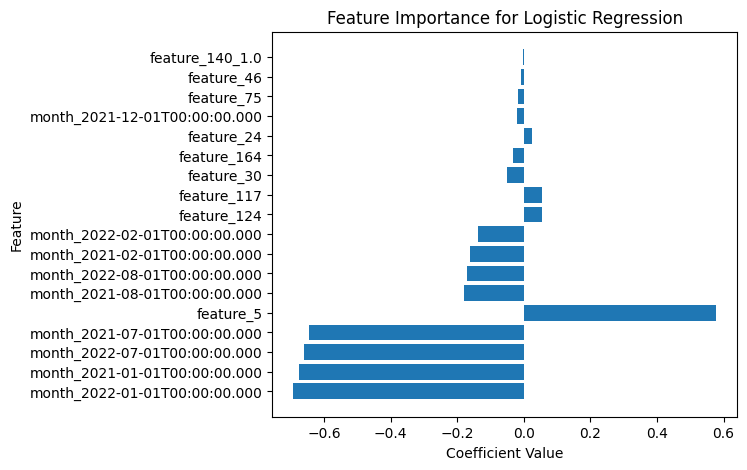

In [218]:
#Будем смотреть на важность по абсолютным значениям коэффициентов (это можно делать, тк мы отскейлили перед этим)
# Получение коэффициентов модели
coefficients = logreg.named_steps['regression'].coef_[0]

coef_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})

# Сортировка коэффициентов по их абсолютным значениям
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(6, 5))
plt.barh(sorted_coef_df['Feature'], sorted_coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance for Logistic Regression')
plt.show()

# Бонусная часть (3 балла)

В разделе про бустинг мы обучали `LGBMClassifier` на довольно большом наборе фичей. Их количество можно сократить, при этом не теряя в качестве модели.

За начальный набор признаков можно взять все признаки (все 230) или признаки после отбора по IV.

**Ваша задача:** Отобрать признаки, подобрать оптимальные гиперпараметры и обучить `LGBMClassifier`.

Задание творческое) Можно использовать любые методы отбора признаков / оптимизации гиперпараметров.

**Чем меньше признаков, без ухудшения качества модели – тем лучше.**

In [195]:
#будем работать с фичами отобранными после IV
df_good = df[list(features_optuna) + ['target'] + ['sample_part']]

In [196]:
df_good[categorical_features_with_good_iv].isna().sum()

encoded_date         0
feature_147          0
feature_144          0
feature_168          0
feature_165          0
feature_10      166667
feature_31           0
feature_140      36943
feature_0            0
feature_161      51390
feature_209          0
feature_62       62647
dtype: int64

In [197]:
#для начала закодируем категориальные используя target_encoding
import category_encoders as ce

target_encoder = ce.TargetEncoder()
df_good.loc[:,'feature_10'] = df_good['feature_10'].fillna('missing')
df_good.loc[:,'feature_140'] = df_good['feature_140'].fillna('missing')
df_good.loc[:,'feature_161'] = df_good['feature_161'].fillna('missing')
df_good.loc[:,'feature_62'] = df_good['feature_62'].fillna('missing')

df_good.loc[:, categorical_features_with_good_iv] = np.float64(target_encoder.fit_transform(
    df_good[categorical_features_with_good_iv],  
    df_good['target']  
))
df_good.loc[:,categorical_features_with_good_iv] = df_good[categorical_features_with_good_iv].astype(float)

In [198]:
df_good[numeric_features_with_good_iv].isna().sum().sort_values(ascending = False)

feature_223    73488
feature_172    61880
feature_124    58984
feature_115    43255
feature_30     34475
feature_183        0
feature_97         0
feature_135        0
feature_26         0
feature_2          0
feature_46         0
feature_100        0
feature_111        0
feature_164        0
feature_98         0
feature_36         0
feature_4          0
feature_27         0
feature_132        0
feature_32         0
feature_206        0
feature_70         0
feature_44         0
feature_23         0
feature_170        0
feature_39         0
feature_94         0
feature_76         0
feature_9          0
feature_155        0
feature_15         0
feature_154        0
feature_218        0
feature_96         0
feature_225        0
feature_162        0
feature_167        0
feature_109        0
feature_79         0
feature_213        0
feature_117        0
feature_38         0
feature_24         0
feature_75         0
feature_5          0
feature_56         0
feature_114        0
feature_139  

In [199]:
#теперь заполним пропуски для числовых фичей средним значением
df_good.loc[df_good['feature_223'].isna(), 'feature_223'] = df_good.feature_223.mean()
df_good.loc[df_good['feature_124'].isna(), 'feature_124'] = df_good.feature_124.mean()
df_good.loc[df_good['feature_172'].isna(), 'feature_172'] = df_good.feature_172.mean()
df_good.loc[df_good['feature_115'].isna(), 'feature_115'] = df_good.feature_115.mean()
df_good.loc[df_good['feature_30'].isna(), 'feature_30'] = df_good.feature_30.mean()

Идеи для отбора признаков:

- Воспользоваться методами из модуля `sklearn.feature_selection` (точно можно попробовать RFE). Документация https://scikit-learn.org/stable/modules/feature_selection.html
- С помощью `BorutaPy` из библиотеки `boruta` (https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a – статья может помочь разобраться с запуском алгоритма (мб не откроется без vpn))


In [200]:
df_good[categorical_features_with_good_iv] = df_good[categorical_features_with_good_iv].astype(float)

C:\Users\kamil\AppData\Local\Temp\ipykernel_27912\1656967482.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [201]:
features_optuna.shape

(65,)

In [220]:
#from boruta import  BorutaPy
#я использую такой код для импорта боруты, тк для нормальной работы нужно было поменять в коде библиотеки np.int, np.float, np.bool, но vs code почему то не видит эту замену поэтому пришлось импортить напрямую
import importlib.util
import sys
module_path = 'C:/Users/kamil/AppData/Local/Programs/Python/Python312/Lib/site-packages/boruta/boruta_py.py'

spec = importlib.util.spec_from_file_location("BorutaPy", module_path)

module = importlib.util.module_from_spec(spec)

spec.loader.exec_module(module)

In [280]:
# bb = LGBMClassifier()
# feat_selector = module.BorutaPy(bb, n_estimators=100, verbose=2, random_state=42)

# # find all relevant features
# feat_selector.fit(
#     X=df_good.loc[df_good['sample_part'] == 'train', features_optuna].values,
#     y=df_good.loc[df_good['sample_part'] == 'train', 'target'].values
# )


In [281]:
#features_optuna[feat_selector.support_]

In [227]:
#борута отобрал 62 фичи из 65
features_selected_boruta = np.array(['feature_9', 'feature_15', 'feature_154', 'feature_218',
       'feature_96', 'feature_223', 'feature_30', 'feature_225',
       'feature_162', 'feature_167', 'feature_109', 'feature_124',
       'feature_79', 'feature_213', 'feature_117', 'feature_38',
       'feature_24', 'feature_75', 'feature_5', 'feature_56',
       'feature_114', 'feature_139', 'feature_142', 'feature_12',
       'feature_35', 'feature_227', 'feature_115', 'feature_155',
       'feature_132', 'feature_76', 'feature_97', 'feature_135',
       'feature_26', 'feature_2', 'feature_46', 'feature_100',
       'feature_111', 'feature_164', 'feature_98', 'feature_36',
       'feature_183', 'feature_27', 'feature_4', 'feature_32',
       'feature_206', 'feature_172', 'feature_70', 'feature_44',
       'feature_23', 'feature_170', 'feature_39', 'feature_94',
       'feature_43', 'feature_147', 'feature_144', 'feature_168',
       'feature_165', 'feature_10', 'feature_31', 'feature_140',
       'feature_0', 'feature_209'])

In [255]:
from sklearn.feature_selection import RFE
clf = LGBMClassifier()
rfe = RFE(clf, n_features_to_select=53)
rfe.fit(
    X=df_good.loc[df_good['sample_part'] == 'train', features_selected_boruta],
    y=df_good.loc[df_good['sample_part'] == 'train', 'target']
)

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13593
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13338
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM]

RFE(estimator=LGBMClassifier(), n_features_to_select=53)

In [261]:
selected_rfe = features_selected_boruta[rfe.support_]

In [282]:
selected_rfe

array(['feature_9', 'feature_15', 'feature_154', 'feature_96',
       'feature_223', 'feature_30', 'feature_225', 'feature_162',
       'feature_167', 'feature_109', 'feature_124', 'feature_79',
       'feature_213', 'feature_117', 'feature_38', 'feature_24',
       'feature_75', 'feature_5', 'feature_56', 'feature_114',
       'feature_139', 'feature_12', 'feature_35', 'feature_227',
       'feature_115', 'feature_155', 'feature_132', 'feature_76',
       'feature_97', 'feature_135', 'feature_26', 'feature_2',
       'feature_46', 'feature_100', 'feature_111', 'feature_164',
       'feature_98', 'feature_36', 'feature_183', 'feature_27',
       'feature_206', 'feature_70', 'feature_44', 'feature_23',
       'feature_170', 'feature_43', 'feature_147', 'feature_144',
       'feature_168', 'feature_10', 'feature_140', 'feature_0',
       'feature_209'], dtype='<U11')

In [258]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves',2, 200),
        'n_estimators': trial.suggest_int('n_estimators',100,1000),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples',10,30),
        'reg_lambda' : trial.suggest_float('reg_lambda',0.001,10, log=True),
        'reg_alpha' : trial.suggest_float('reg_alpha',0.001,10, log=True),
        "max_depth": trial.suggest_int("max_depth", 50, 1000),

        'random_state': 42
    }
    
    clf = LGBMClassifier(**params)
    clf.fit(
        X=df_good.loc[df_good['sample_part'] == 'train', selected_rfe],
        y=df_good.loc[df_good['sample_part'] == 'train', 'target']
    )
    preds = clf.predict_proba(df_good.loc[df_good['sample_part'] == 'val', selected_rfe])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df_good.loc[df_good['sample_part'] == 'val', 'target'],
        y_score=preds
    )
    
    return auc_valid

In [283]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [284]:
#print(study.best_params)

In [285]:
#Я снова запускал подбор параметров несколько раз и это лучший набор
best_parametrs = {'learning_rate': 0.04956180360854471, 'num_leaves': 178, 'n_estimators': 756, 'subsample': 0.2559190625656913, 'colsample_bytree': 0.6825224396289944, 'min_child_samples': 17, 'reg_lambda': 0.23399254053035093, 'reg_alpha': 9.757452314703851, 'max_depth': 156}


In [286]:
clf = LGBMClassifier(**best_parametrs)
clf.fit(
    X=df_good.loc[df_good['sample_part'] == 'train', selected_rfe],
    y=df_good.loc[df_good['sample_part'] == 'train', 'target']
)

preds_test = clf.predict_proba(df_good.loc[df_good['sample_part'] == 'test', selected_rfe])[:, 1]
auc_test = roc_auc_score(
    y_true=df_good.loc[df_good['sample_part'] == 'test', 'target'],
    y_score=preds_test
)
auc_test

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11803
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


0.7375490981078134

**Вывод:** Используя отбор по IV, Boruta, RFE у меня получилось отобрать 53 фичи из 65 без потери качества относительно бустинга, который был только после отбора по IV. В общем количество фичей сократилось с 230 до 53.

Напоминаю, что auc в начале домашки у меня получился 0.738